# Graphical comparison of differences between distributions

This notebook showcases functions which can be used to visualise and analyse differences between the distributions of different samples.  

> To have a quick look at the plots, jump to the examples in the last third of this notebook.

To demonstrate these functions, I will look at various two-tailed and one-tailed statistical tests as a way of showing how the same conclusions which are shown graphically are also supported numerically. 

In [1]:
# enables nice interactive plots in jupyter. Requires ipympl to be installed
%matplotlib widget      

import pandas as pd
import numpy as np
import scipy.stats  #for KS test

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import shapely
import shapely.validation
import shapely.ops

import IPython.display

## Statistical tests to compare two samples: means, variances, and distributions - two-tailed and one-tailed

There are many statistical tests to compare two samples: Some compare the **means** of the two samples, some compare the **standard deviations**. 

Then there are some tests which look at the **entire distribution** and answer the question: are these two samples from the same disstribution? Or, more precisely, if we assume that the same distribution is shared by both samples, that both samples are drawn from the same underlying distribution, then what is the probability of the actual samples being observed?

Tests like this are also sensitive to differences in means and differences in variance of the data. However just considering means and variances is often not enough. For example, a Uniform $\mathcal{U}(-\sqrt{3}, \sqrt{3})$ has mean $\mu_\mathcal{\tiny{U}}=0$ and variance $\sigma^2_\mathcal{\tiny{U}}=\frac{1}{12}(a-b)^2=\frac{1}{12}(2\sqrt{3})^2=1$, and it is perfectly possible to have a Gaussian distribution which also has mean $\mu_\mathcal{\tiny{N}}=0$ and variance $\sigma^2_\mathcal{\tiny{N}}=1$, i.e. $\mathcal{N}(0,1)$ - yet they are entirely different distributions with different PDFs and CDFs.



#### Function to generate two samples

To demonstrate this, we first need to make a function which generates two samples which have given sample means and variances and specified distributions. We can then make two samples from different distributions which share mean and variance and show which tests are able to pick up on this.

In [2]:
def generate_two_samples(a_mean=0, a_std=1, a_dist=scipy.stats.norm, a_kwargs={}, sample_a_name=None, 
                         b_mean=0, b_std=1, b_dist=scipy.stats.norm, b_kwargs={}, sample_b_name=None, 
                         size=500, display_description=True, seed=0):

    if sample_a_name==None: 
        if a_dist!=b_dist:  sample_a_name = a_dist.name
        else:               sample_a_name = 'a'
    if sample_b_name==None: 
        if a_dist!=b_dist:  sample_b_name = b_dist.name
        else:               sample_b_name = 'b'

    rng = np.random.default_rng(seed) 

    a = a_dist.rvs(loc=0, scale=1, size=size, random_state=rng, **a_kwargs)

    b = b_dist.rvs(loc=0, scale=1, size=size, random_state=rng, **b_kwargs)


    a = a * (a_std / a.std(ddof=1))
    a = (a + (a_mean-a.mean())) 

    b = b * (b_std / b.std(ddof=1))
    b = (b + (b_mean-b.mean())) 


    a_ = pd.DataFrame(a, columns=['x'])
    a_['type']=sample_a_name

    b_ = pd.DataFrame(b, columns=['x'])
    b_['type']=sample_b_name

    both_samples_different_distributions = pd.concat([a_, b_])


    if display_description:    
        IPython.display.display(pd.concat([
            a_                                      .describe().rename(columns={'x':sample_a_name}),
            b_                                      .describe().rename(columns={'x':sample_b_name}),
            both_samples_different_distributions    .describe().rename(columns={'x':'all_data'}),
                ], axis=1).round(5))
        
    return both_samples_different_distributions



two_samples_Normal_Uniform = generate_two_samples(
                        a_dist=scipy.stats.norm,    a_mean=0, a_std=1, 
                        b_dist=scipy.stats.uniform, b_mean=0, b_std=1, 
                        size=1500, display_description=True, seed=0)



,norm,uniform,all_data
count,1500.00000,1500.00000,3000.00000
mean,0.00000,0.00000,0.00000
std,1.00000,1.00000,0.99983
min,-3.92574,-1.69247,-3.92574
25%,-0.67207,-0.84958,-0.75115
50%,-0.00605,-0.06747,-0.03741
75%,0.68595,0.85588,0.76937
max,3.11406,1.78858,3.11406


#### Visualisation functions

Visualisations are always the quickest way to easily get to grips with data, so to see how the two samples differ we need functions which will help us visualise them. 

To do this, we will plot the empirical PDFs and CDFs of the two samples, and finally a QQ-plot which shows the quantiles of the two samples. So a figure with three subplots.

First we define a few helper functions:


In [3]:
def axvline_with_xtick(ax, x, colour='grey', axvline_kwargs=dict(ls='-', alpha=.25), 
                       xtick_label_dp=2):
    '''draws a vertical line on the given ax at the specified value of x. Annotates the position on the x-axis.'''
    ax.axvline(x, c=colour, **axvline_kwargs)

    ax.annotate(text=str(round(x, xtick_label_dp)),
                # the x coords of this transformation are data, and the y coord are axes
                # https://matplotlib.org/stable/tutorials/advanced/transforms_tutorial.html#blended-transformations
                transform = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes),
                xy=(x, ax.get_ylim()[0]),
                xytext=(0, -7), textcoords='offset points', color=colour, 
                #  rotation=90, 
                ha='center', va='top',
                arrowprops=dict(arrowstyle='-', color=colour, ),
                bbox=dict(fc='white', ec='white', alpha=.9, pad=0)
    )


def axhline_with_ytick(ax, y, colour='grey', axhline_kwargs=dict(ls='-', alpha=.25), 
                       ytick_label_dp=2):
    '''draws a horizontal line on the given ax at the specified value of y. Annotates the position on the y-axis.'''

    ax.axhline(y, c=colour, **axhline_kwargs)

    ax.annotate(text=str(round(y, ytick_label_dp)),
                # the x coords of this transformation are axes, and the y coord are data
                # https://matplotlib.org/stable/tutorials/advanced/transforms_tutorial.html#blended-transformations
                transform = matplotlib.transforms.blended_transform_factory(ax.transAxes, ax.transData),
                xy=(ax.get_xlim()[0], y),
                xytext=(-7,0), textcoords='offset points', color=colour, 
                #  rotation=90, 
                ha='right', va='center',
                arrowprops=dict(arrowstyle='-', color=colour, ),
                bbox=dict(fc='white', ec='white', alpha=.9, pad=0)
    )


# quick demonstration:
# fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
# x=np.arange(6)
# y=np.arange(6)-2
# ax1.scatter(x, y)
# ax2.scatter(x, y)
# ax3.scatter(x, y)
# axvline_with_xtick(ax=ax1, x=2.5)
# axhline_with_ytick(ax=ax2, y=1.5)
# axvline_with_xtick(ax=ax3, x=2.5)
# axhline_with_ytick(ax=ax3, y=1.5)
# plt.show()
           


In [4]:

def informative_legend(ax, a, sample_a_name, b, sample_b_name, dp=3):
    '''change labels on legend to include mean and variance of both samples a and b'''
    # print(a, sample_a_name, b, sample_b_name, sep='\n')
    handles = ax.get_legend().legendHandles
    labels = [item.get_text() for item in ax.get_legend().get_texts()]
    for i, label in enumerate(labels):
        if label==sample_a_name:      
            labels[i] = (
            '$X_a$ (' + sample_a_name
            + ') :' + 
            '\n $' + 
            '\hat{\mu}_a=' + str(round(a.x.mean(), dp) + 0) + ', ' +    #if mean is given as -0.0, adding 0 changes it to 0.0
            '\hat{\sigma}^2_a=' + str(round(a.x.std()**2, dp) ) 
            +'$')
        elif label==sample_b_name:
            labels[i] = (
            '$X_b$ (' + sample_b_name
            + ') :' + 
            '\n $' + 
            '\hat{\mu}_b=' + str(round(b.x.mean(), dp) + 0) + ', ' +    #if mean is given as -0.0, adding 0 changes it to 0.0
            '\hat{\sigma}^2_b=' + str(round(b.x.std()**2, dp) )   
            +'$')
    ax.legend(handles, labels, loc='upper left', fontsize='small')



In [5]:
def make_valid_polygon(pg, criteria='max'):
    '''Takes a shapely polygon, checks for geometric validity. 
    If invalid, use shapely make_valid method to fix.
    make_valid can often return a MultiPolygon. This can be undesirable when a polygon is expected in later code. 
    This function finds the largest (or smallest) polygon in the multipolygon, and returns that polygon.

    Args:
        pg (shapely polygon): a shapely polygon which may or may not be valid
        criteria:   'max' means will return largest polygon. 'min' will return polygon with smallest area.
            '''
    
    if pg.is_valid: return pg

    fixed_pg = shapely.validation.make_valid(pg)

    if (type(pg)==shapely.Polygon) and (type(fixed_pg)==shapely.MultiPolygon):
        if criteria=='max':
            chosen_pg = max(fixed_pg.geoms, key = lambda x:x.area)
        if criteria=='min':
            chosen_pg = min(fixed_pg.geoms, key = lambda x:x.area)

        return chosen_pg
    
    else:
        return fixed_pg


def visual_centre(pg):
    '''The centroid of a polygon is not guaranteed to be inside the polygon.
    For example, a polygon in the shape of a U will have the centroid between the arms of the U.
    This function aims to find a point which visually looks like the centre of the polygon.
    It does this by "peeling" the polygon like an onion, removing as much as possible.
    It finds the centroid of the remainder.
    It then finds the point in that remainder which is closest to the centroid of the remainder.
    Thus the visual centre is guaranteed to be inside that remainder.
    This means that the visual centre will be chosen as the place where the largest inscribed circle can be drawn.'''
    
    centre = pg.centroid
    #greatest possible buffer which leaves sthg in the middle is when the polygon is a square 
    # and the buffer is (just under) half the sqrt of the area of the square.
    # all other shapes have smaller max buffers.
    buffers = np.linspace(pg.area**.5 * .4, 0) 
    # print(buffers)
    for buffer in buffers:
        peeled_pg = pg.buffer(distance=-buffer)
        # print(buffer, peeled_pg.area, type(peeled_pg), peeled_pg)
        if not peeled_pg.is_empty:
            # print(peeled_pg.centroid)
            centre = peeled_pg.centroid
            centre = shapely.ops.nearest_points(peeled_pg, centre)[0]
            return centre
    centre = shapely.ops.nearest_points(pg, centre)[0]
    return centre

# visual_centre(pg_segment)


#### Plot the PDFs

First we plot the estimated PDFs of the two samples using [Kernel Density Estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation), along with their histograms.  
The KDE PDF will be annotated with the area of various regions - this will make it easier to compare the PDF to the greatest deviations on the CDF.  
For the same reason, the PDFs have areas shaded on them with diagonal lines. These areas represent the greatest deviations on the CDF (the KS test statistic), which will be explained in more detail later on.


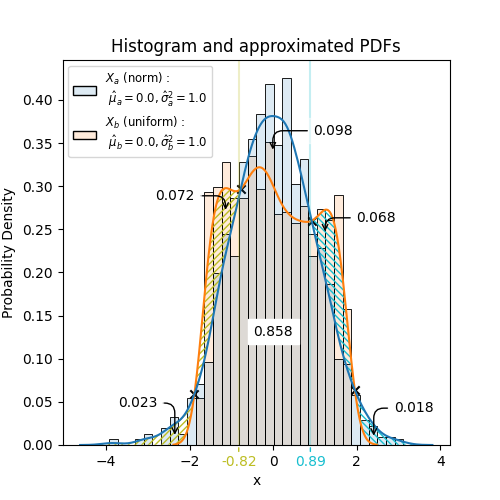

In [6]:
def pdfs_ax(both_samples, col_name_which_IDs_samples='type', 
                ax=None,
                hist_kwargs={}, kde_kwargs={}, axvline_kwargs=dict(ls='-', alpha=.25)):
    '''Creates a plot of the PDFs based on the input DataFrame to compare distribution of two samples.

    Any keywords which are accepted by the functions used here can be passed through.
    '''
    

    #using pd.unique rather than np.unique because pd doesn't sort, so sample_names will be in order of input df
    sample_names = pd.unique(both_samples[col_name_which_IDs_samples])
    assert len(sample_names)==2, 'ERROR - there must be exactly two samples for the x and y axis of the QQ-plot'
    sample_a_name, sample_b_name = sample_names

    a = both_samples[both_samples[col_name_which_IDs_samples] == sample_a_name ]
    b = both_samples[both_samples[col_name_which_IDs_samples] == sample_b_name ]
    
    if ax==None: 
        ax = plt.axes()
        # print(ax)

    # the commented-out line below does the histogram and KDE plot all in one. 
    #  However for our purposes it is beneficial to do these separately, 
    #  so that the coordinates of the KDE plot can be extracted easily.
    # sns.histplot(both_samples, x='x', hue='type', kde=True, stat='probability', common_norm=False, ax=ax, )
    # ax.set_ylabel('Probability / Probability Density')


    # plot KDE plot and histogram separately. Save coordinates of KDE lines, to be used later on.
    sns.kdeplot(both_samples, x='x', hue='type', hue_order=sample_names, common_norm=False, ax=ax, )
    pdf_kde_children = ax.get_children()    # need to save this now, to extract polygon between KDE lines later on

    sns.histplot(both_samples, x='x', hue='type', hue_order=sample_names, kde=False, stat='density', 
                 alpha=.15,  common_norm=False, ax=ax, )


    # If the two samples seem to have different means, draw vertical lines at the means of the two samples, using matching colours.
    if scipy.stats.ttest_ind(a.x, b.x, equal_var=False, alternative='two-sided').pvalue<0.1:
        color1, color2 = pdf_kde_children[0].get_color(), pdf_kde_children[1].get_color()
        ax.axvline(a.x.mean(), c=color2, ls='--', alpha=.1)
        ax.axvline(b.x.mean(), c=color1, ls='--', alpha=.1)


    ax.set_ylabel('Probability Density')


    ax.set_title('Histogram and approximated PDFs')


    # get the data for the kde pdf on the first ax
    x1, y1 = pdf_kde_children[0].get_data()
    x2, y2 = pdf_kde_children[1].get_data()


    # mark the **areas** on the three plots where there is divergence between the two distributions, in both directions

    test_results = [scipy.stats.ks_2samp(a.x, b.x, alternative='less'),
                    scipy.stats.ks_2samp(b.x, a.x, alternative='less'),]
    
    greatest_CDF_dists = sorted([test_result.statistic_location for test_result in test_results if test_result.pvalue<0.05])
    # print(*greatest_CDF_dists, sep='\n')
    
    for i, greatest_CDF_dist in enumerate(greatest_CDF_dists):
        color_this_bit = sns.color_palette()[8+i]

        # plot a vertical line at the location of the greatest deviations between the distributions
        axvline_with_xtick(ax=ax, x=greatest_CDF_dist, colour=color_this_bit, axvline_kwargs=axvline_kwargs)


        # make polygons of the area between the two PDFs, before and after the locations of the greatest deviations between CDFs
        # for the first deviation (on the left), shade from the far left of the PDFs until the location of the deviation
        if i==0: 
            x1_trunc, y1_trunc = x1[x1<=greatest_CDF_dist], y1[x1<=greatest_CDF_dist]
            x2_trunc, y2_trunc = x2[x2<=greatest_CDF_dist], y2[x2<=greatest_CDF_dist]
        # for the second deviation (on the right), shade from the location of the deviation until the far right of the PDFs
        elif i==1: 
            x1_trunc, y1_trunc = x1[x1>=greatest_CDF_dist], y1[x1>=greatest_CDF_dist]
            x2_trunc, y2_trunc = x2[x2>=greatest_CDF_dist], y2[x2>=greatest_CDF_dist]

        # plot the polygons using diagonal lines shading
        polygon_xs = np.append(x1_trunc, x2_trunc[::-1])
        polygon_ys = np.append(y1_trunc, y2_trunc[::-1])
        ax.fill(polygon_xs, polygon_ys,
            alpha=1, facecolor='none', lw=0,
            edgecolor=color_this_bit, 
            # for the deviation on the left  of the plot, use / shading
            # for the deviation on the right of the plot, use \ shading
            hatch=(['/', '\\'][i])*5,    # diagonal lines, going in different directions. *5 means lots of lines
        )




    # convert the 2 KDE PDFs into shapely lines - so can find area, intersections, etc
    line1 = shapely.LineString(list(zip( x1, y1)))
    line2 = shapely.LineString(list(zip( x2, y2)))

    # mark the intersections of the two KDE PDFs
    intersections_points = line1.intersection(line2)
    if type(intersections_points)==shapely.MultiPoint:          #multiple intersections between the two PDF lines
        intersections = np.array([intersection.coords[0] for intersection in intersections_points.geoms])
    elif type(intersections_points)==shapely.Point:             #only one intersection between the two lines
        intersections = np.vstack(intersections_points.xy).T
    elif type(intersections_points)==shapely.LineString:        #no intersections between the two lines - skip the rest!
        return ax
    ax.scatter(intersections[:,0], intersections[:,1], marker='x', color='black')#sns.color_palette()[3])



    # mark the areas of the different regions of the two KDE PDFs

    # FIRST, mark the intersection of both PDFs, i.e. where both overlap - annotate it with the area of the intersection

    pg1 = make_valid_polygon(shapely.Polygon(list(line1.coords)))
    pg2 = make_valid_polygon(shapely.Polygon(list(line2.coords)))

    pg_segment_intersection = shapely.intersection(pg1, pg2)
    pg_segment_intersection_centroid = np.array(pg_segment_intersection.centroid.coords)[0]
    ax.annotate(text=str(round(pg_segment_intersection.area, 3)), 
                xy = pg_segment_intersection_centroid,
                ha='center', 
                va='bottom', #c='blue',
                arrowprops={},  #no arrow for this one
                bbox=dict(fc='white', ec='white', alpha=1),)


    # SECOND, make a polygon which includes both pdfs, i.e. the union. 
    #  This will be useful to know where to put annotations later, as we want them outside the pdf union.
    pg_both_pdfs_union = shapely.unary_union([pg1, pg2])
    pg_both_pdfs_union_centroid = np.array(pg_both_pdfs_union.centroid.coords)[0]

    # transform the polygon of both pdfs from data coordinates to display coordinates
    # (this is important so that "the closest place" calculated to put annotations, depends on closeness in pixels,
    #  and not on closeness in the units of the axis - as the y-axis generally has small units, this is important)
    pg_both_pdfs_union_in_display_coords = shapely.Polygon(
        ax.transData.transform(np.vstack((pg_both_pdfs_union).exterior.coords.xy).T))

    # now add a buffer around the union of PDFs. The size of the buffer is .1 * the size of the radius of the bounding circle
    pg_both_pdfs_union_in_display_coords = shapely.buffer(pg_both_pdfs_union_in_display_coords, 
        distance=shapely.minimum_bounding_radius(pg_both_pdfs_union_in_display_coords)*.1)

    # finally, to ensure annotations aren't placed under the PDFs, e.g. at y=-0.05, we 
    #   add a big box to the polygon of the PDFs and attach it underneath the PDFs. 
    #   That will mean that under the PDFs is never the best place to place the annotations.
    pg_union_xmin, pg_union_ymin, pg_union_xmax, pg_union_ymax = pg_both_pdfs_union_in_display_coords.bounds
    pg_both_pdfs_union_with_square_underneath = shapely.union(pg_both_pdfs_union_in_display_coords, 
        shapely.box(xmin=pg_union_xmin, xmax=pg_union_xmax, 
                    ymin=-pg_union_ymax, ymax=pg_union_ymin*.975 + pg_union_ymax*.025, ))


    # THIRD, find other regions (the bits covered by only one of the two PDFs) by using each line to split the other
    line1_segments = shapely.ops.split(line1, line2)
    line2_segments = shapely.ops.split(line2, line1)

    for line1_segment, line2_segment in zip(line1_segments.geoms, line2_segments.geoms):
        # make polygons for each segment, using the split lines
        pg_segment = shapely.Polygon([*list(line1_segment.coords), *(list(line2_segment.coords)[::-1])])

        pg_segment_area = pg_segment.area
        
        # don't label very small segments - if it is small, jump to the next
        if pg_segment_area < 0.002:
            continue


        # get arrowhead in visual centre of segment, using visual_centre function
        pg_segment_in_display_coords = shapely.Polygon(
            ax.transData.transform(np.vstack(pg_segment.exterior.coords.xy).T))
        arrowhead_pos_in_display_coords = visual_centre(pg_segment_in_display_coords)

        arrowhead_pos = ax.transData.inverted().transform(arrowhead_pos_in_display_coords.xy)[0]


        # work out where the text of the annotation should be (outside the PDFs).
        # First, find the nearest point on the boundary of the buffered PDFs
        text_pos = shapely.ops.nearest_points(pg_both_pdfs_union_with_square_underneath.boundary, arrowhead_pos_in_display_coords)
        # Second, convert that point back into Data coords
        text_pos = ax.transData.inverted().transform(list(text_pos)[0].xy)[0]

        ax.annotate(text=str(round(pg_segment_area, 3)), 
                    xy = arrowhead_pos,             # arrowhead at visual centre of segment
                    xytext = text_pos,              # text in closest position outside buffered PDFs
                    ha=('left' if text_pos[0]>pg_both_pdfs_union_centroid[0] else 'right'), 
                    va='bottom', #c='blue',
                    arrowprops=dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=90,rad=10", shrinkA=0, shrinkB=0),
                    bbox=dict(fc='white', ec='white', alpha=.5),
                    )

    informative_legend(ax, a, sample_a_name, b, sample_b_name, dp=3)

    return ax

demo_fig, demo_ax = plt.subplots(figsize=(5,5))
ax = pdfs_ax(both_samples=two_samples_Normal_Uniform, col_name_which_IDs_samples='type', ax=demo_ax)
plt.show()

The area of each segment between the KDE curves is marked. Note that the areas under each of the two PDF curves add to approximately one. (This isn't exact due to rounding of the areas, and due to treating the curves as polygons).  

The areas shaded with / and \ lines, as well as the vertical lines with ticks on the x-axis, relate to the Kolmogorov-Smirnov test for equal distributions, and will be discussed later.


#### Plot the CDFs

Second, we plot the empirical CDFs, and the estimated CDFs of the two samples using [Kernel Density Estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation).  
The CDF will be annotated with the greatest deviations between the two CDFs.  


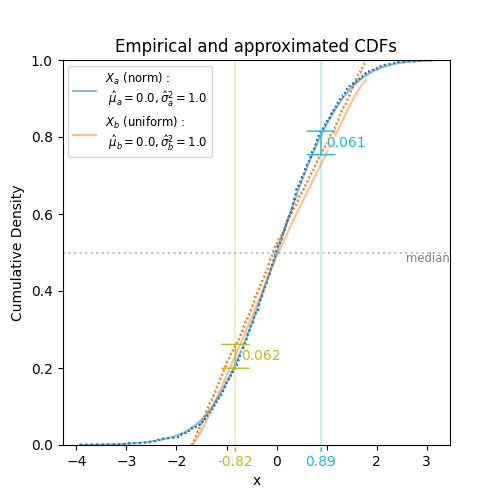

In [7]:
def cdfs_ax(both_samples, col_name_which_IDs_samples='type', 
                kde_kwargs={}, ecdf_kwargs={}, axvline_kwargs=dict(ls='-', alpha=.25,), # hist_kwargs={}, 
                ax=None,):
    '''Creates a plot of the CDFs based on the input DataFrame to compare distribution of two samples.

    Uses sns, so any keywords which are accepted by that can be passed through.

    Args:
        data (_type_): _description_
    '''

    #using pd.unique rather than np.unique because pd doesn't sort, so sample_names will be in order of input df
    sample_names = pd.unique(both_samples[col_name_which_IDs_samples])
    assert len(sample_names)==2, 'ERROR - there must be exactly two samples for the x and y axis of the QQ-plot'
    sample_a_name, sample_b_name = sample_names

    a = both_samples[both_samples[col_name_which_IDs_samples] == sample_a_name ]
    b = both_samples[both_samples[col_name_which_IDs_samples] == sample_b_name ]
    
    if ax==None: 
        print(ax)
        ax = plt.axes()
        print(ax)


    sns.ecdfplot(both_samples, x='x', hue='type', hue_order=sample_names, ax=ax,  linestyle=':', **ecdf_kwargs)
    ax_kde = sns.kdeplot(both_samples, x='x', hue='type', hue_order=sample_names, common_norm=False, cut=0.0, alpha=.5, cumulative=True, 
                          ax=ax, **kde_kwargs)
    # sns.histplot(both_samples, x='x', hue='type', hue_order=sample_names, kde=True, stat='probability', common_norm=False, cumulative=True, 
    #               ax=ax, **hist_kwargs)
    

    # draw horizontal line at 0.5 to show median
    ax.axhline(.5, c='gray', ls=':', alpha=.5)
    ax.annotate(text='median', xy=(ax.get_xlim()[1], 0.5), va='top', ha='right', 
                 c='gray', size='small')

    # If the two samples seem to have different means, draw vertical lines at the means of the two samples, using matching colours.
    if scipy.stats.ttest_ind(a.x, b.x, equal_var=False, alternative='two-sided').pvalue<0.1:
        color1, color2 = ax_kde.get_children()[0].get_color(), ax_kde.get_children()[1].get_color()
        ax.axvline(a.x.mean(), c=color2, ls='--', alpha=.1)
        ax.axvline(b.x.mean(), c=color1, ls='--', alpha=.1)
    

    ax.set_title('Empirical and approximated CDFs')
    ax.set_ylabel('Cumulative Density')







    # mark the positions on the three plots where there is divergence between the two distributions, in both directions

    test_results = [
        # scipy.stats.ks_2samp(a.x, b.x, alternative='two-sided'),
        scipy.stats.ks_2samp(a.x, b.x, alternative='less'),
        scipy.stats.ks_2samp(b.x, a.x, alternative='less'),
        ]
    
    # print(*test_results, sep='\n')

    greatest_CDF_dists = sorted([test_result for test_result in test_results if test_result.pvalue<0.05],
                                    key=lambda x:x.statistic_location)
    # print(*greatest_CDF_dists, sep='\n')
    
    for i, greatest_CDF_dist in enumerate(greatest_CDF_dists):
        color_this_bit = sns.color_palette()[8+i]

        # plot a vertical line at the location of the greatest deviations between the distributions
        axvline_with_xtick(ax=ax, x=greatest_CDF_dist.statistic_location, colour=color_this_bit, axvline_kwargs=axvline_kwargs)

        xy_a = (greatest_CDF_dist.statistic_location, (a.x <= greatest_CDF_dist.statistic_location).mean())
        xy_b = (greatest_CDF_dist.statistic_location, (b.x <= greatest_CDF_dist.statistic_location).mean())
        # print(xy_a, xy_b)

        # plot a dark marker which shows the deviations between the CDFs at the locations where it is greatest 
        ax.annotate(text='', 
                     xy=xy_a, xytext=xy_b, xycoords='data', 
                     arrowprops=dict(arrowstyle='|-|', color=color_this_bit, shrinkA=0, shrinkB=0))
        ax.annotate(text='' + str(round(greatest_CDF_dist.statistic, 3)), 
                     xy=(greatest_CDF_dist.statistic_location, 
                        ((a.x <= greatest_CDF_dist.statistic_location).mean() + (b.x <= greatest_CDF_dist.statistic_location).mean()) / 2 ), 
                     xycoords='data', va='center',
                     xytext=(4, 0), textcoords='offset points',
                     color=color_this_bit, 
                    #  arrowprops=dict(arrowstyle='|-|', color=color_this_bit, )
                    bbox=dict(fc='white', ec='white', alpha=.5, pad=0),
                     )
        # print(' ' + str(round(test_results[i].statistic, 3)), test_results[i].statistic)


    informative_legend(ax, a, sample_a_name, b, sample_b_name, dp=3)


    return ax

demo_fig, demo_ax = plt.subplots(figsize=(5,5))
cdfs_ax(both_samples=two_samples_Normal_Uniform, col_name_which_IDs_samples='type', ax=demo_ax)
plt.show()

The greatest deviations between the two CDFs is the statistic used by the Kolmogorov-Smirnov test, and are marked on the CDF: One for each CDF being greater than the other.


#### Axis QQ-plot

The last step is to write a function which draws a pretty QQ-plot.  

This currently only works for samples of equal sizes. Adding interpolation so that the function can handle different sample sizes is on the to-do list!

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 1.25, 'type': 'set_device_pixel_ratio'}


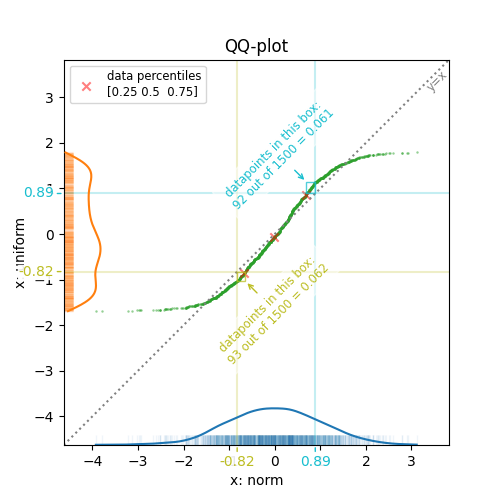

In [8]:
def qq_plot_ax(both_samples, xy_col_name, col_name_which_IDs_samples='type', 
               annotate_quantiles=[], space_for_kde_plot=0.1, ax=None,
                scatter_kwargs={}, rug_kwargs={}, kde_kwargs={}, axvline_kwargs=dict(ls='-', alpha=.25)):
    '''Creates a QQ-plot based on the input DataFrame to compare distribution of two samples.

    Any keywords which are accepted by the underlying plotting functions can be passed through.
    The two samples MUST be of equal length.

    Args:
        both_samples (pd df): the two samples
    '''
    # %matplotlib widget      

    #using pd.unique rather than np.unique because pd doesn't sort, so sample_names will be in order of input df
    sample_names = pd.unique(both_samples[col_name_which_IDs_samples])
    assert len(sample_names)==2, 'ERROR - there must be exactly two samples for the x and y axis of the QQ-plot'
    sample_a_name, sample_b_name = sample_names
    both_samples_have_same_size = (both_samples[col_name_which_IDs_samples]==sample_a_name).sum()==len(both_samples)/2
    assert both_samples_have_same_size, 'ERROR - the two samples must be the identical size for the QQ-plot'

    sample_a_name_new = xy_col_name+': '+sample_a_name
    sample_b_name_new = xy_col_name+': '+sample_b_name
    

    # print(sample_a_name, sample_b_name)
    a = both_samples[both_samples[col_name_which_IDs_samples] == sample_a_name ]
    b = both_samples[both_samples[col_name_which_IDs_samples] == sample_b_name ]
    
    a_sorted = a.sort_values(by=xy_col_name).rename(columns={xy_col_name:sample_a_name_new}).reset_index()
    b_sorted = b.sort_values(by=xy_col_name).rename(columns={xy_col_name:sample_b_name_new}).reset_index()

    rearranged = pd.concat([a_sorted, b_sorted], axis=1, )

    if ax==None: ax = plt.subplot()

    # plot the scatters for the QQ-plot
    ax = sns.scatterplot(data=rearranged,  x=sample_a_name_new, y=sample_b_name_new,  
                  s=3, marker='o', alpha=.5, linewidth=0, ax=ax, color=sns.color_palette()[2], **scatter_kwargs)



    # plot the rugplot to show the marginal distributions of both variables on the QQ-plot
    rugplot_alpha=np.clip(.01*10000/len(a), 0.0019608, 1)      #0.0019608 - dark. 0.0019606 - disappears completely!
    # print(rugplot_alpha)
    sns.rugplot(data=rearranged,  x=sample_a_name_new, ax=ax, 
                # Show the density of a larger dataset using thinner lines and alpha blending:
                lw=.0001, alpha=rugplot_alpha, color=sns.color_palette()[0], **rug_kwargs, )

    sns.rugplot(data=rearranged,  y=sample_b_name_new, ax=ax, 
                # Show the density of a larger dataset using thinner lines and alpha blending:
                lw=.0001, alpha=rugplot_alpha, color=sns.color_palette()[1], **rug_kwargs, )

    
    lims = [min(plt.ylim()[0], plt.xlim()[0]),    max(plt.ylim()[1], plt.xlim()[1])]
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect('equal')

    # add y=x line
    ax.plot(lims, lims, c='gray', ls=':')
    yx_annotation_position = lims[1] - 0.02 * (lims[1]-lims[0])
    ax.annotate(text='y=x', xy=(yx_annotation_position,yx_annotation_position), va='top', ha='right', size='small',
                rotation=45, rotation_mode='anchor', c='gray', )


    # add scatter points to show where the quantiles of the data are. (annotating the quantiles is commented out)
    if type(annotate_quantiles)==int:   annotate_quantiles=np.linspace(0,1,annotate_quantiles, endpoint=False)[1:]
    annotation_idxs = (np.array(annotate_quantiles)*(len(rearranged)-1)).round().astype(int)
    # print(annotate_quantiles, annotation_idxs)
    for i, annotation_idx in enumerate(annotation_idxs):
        point = rearranged.iloc[annotation_idx]
        # print(point)
        # annotation_text = str(round(annotation_idx/len(rearranged)*100)) + 'th percentile'
        # ax.annotate(annotation_text, xy=(point[sample_a_name_new], point[sample_b_name_new]), va='top')
        ax.scatter(point[sample_a_name_new], point[sample_b_name_new], c='r', marker='x', alpha=.5,
            label=('data percentiles\n' +str(annotate_quantiles) if i==0 else ''))

    ax.set_title('QQ-plot')

    ax.legend(loc='upper left', fontsize='small')



    # plot the kdeplot to show the marginal distributions of both variables on the QQ-plot
    # to do this, we need to create new axes on top of the ax which holds the main QQ-scatterplot
    # I.e. in the same position, but using only a small portion of the space, depending on space_for_kde_plot arg

    # First we do the kde for the x-axis variable, on ax2:  
    ax2_pos = ax.get_position()
    ax2_pos.y1 = ax2_pos.y0 + (ax2_pos.y1 - ax2_pos.y0) * space_for_kde_plot
    ax2 = plt.gcf().add_axes(ax2_pos,
            frame_on=False)        # no white background - want it transparent, so doesn't obscure scatter
    sns.kdeplot(data=a, x='x', ax=ax2, cut=0, color=sns.color_palette()[0], **kde_kwargs)
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_xticks([])
    ax2.set_yticks([])

    # Then we do the kde for the y-axis variable, on ax3:  
    ax3_pos = ax.get_position()
    ax3_pos.x1 = ax3_pos.x0 + (ax3_pos.x1 - ax3_pos.x0) * space_for_kde_plot
    ax3 = plt.gcf().add_axes(ax3_pos,
            frame_on=False)        # no white background - want it transparent, so doesn't obscure scatter
    sns.kdeplot(data=b, y='x', ax=ax3, cut=0, color=sns.color_palette()[1], **kde_kwargs)
    ax3.set_ylim(ax.get_ylim())
    ax3.set_xlabel('')
    ax3.set_ylabel('')
    ax3.set_xticks([])
    ax3.set_yticks([])


    # plot vertical and horizontal lines at the location of the greatest deviations between the distributions
    test_results = [scipy.stats.ks_2samp(a.x, b.x, alternative='less'),
                    scipy.stats.ks_2samp(b.x, a.x, alternative='less'),]
    

    # mark the greatest deviations on the QQ-plot (i.e. the KS test statistic)

    greatest_CDF_dists = sorted([test_result for test_result in test_results if test_result.pvalue<0.05],
                                    key=lambda x:x.statistic_location)
    # print(*greatest_CDF_dists, sep='\n')
    
    for i, greatest_CDF_dist in enumerate(greatest_CDF_dists):
        color_this_bit = sns.color_palette()[8+i]

        # plot a vertical line at the location of the greatest deviations between the distributions
        axvline_with_xtick(ax=ax, x=greatest_CDF_dist.statistic_location, colour=color_this_bit, axvline_kwargs=axvline_kwargs)
        axhline_with_ytick(ax=ax, y=greatest_CDF_dist.statistic_location, colour=color_this_bit, axhline_kwargs=axvline_kwargs)


        # find datapoints which represent the greatest deviations between the two distributions
        in_NW_quadrant = rearranged[(rearranged[sample_a_name_new] <= greatest_CDF_dist.statistic_location) 
                                  & (rearranged[sample_b_name_new] >  greatest_CDF_dist.statistic_location)]
        in_SE_quadrant = rearranged[(rearranged[sample_a_name_new] >  greatest_CDF_dist.statistic_location) 
                                  & (rearranged[sample_b_name_new] <= greatest_CDF_dist.statistic_location)]

        # draw annotated boxes containing datapoints which represent the greatest deviations between the two distributions
        if len(in_NW_quadrant)>0:
            rectangle_NW_quadrant = plt.Rectangle(xy=(in_NW_quadrant[sample_a_name_new].min(), greatest_CDF_dist.statistic_location),
                                    width=greatest_CDF_dist.statistic_location-in_NW_quadrant[sample_a_name_new].min(),
                                    height=in_NW_quadrant[sample_b_name_new].max()-greatest_CDF_dist.statistic_location,
                                    color=color_this_bit, alpha=.75, fill=False, )
            ax.add_artist(rectangle_NW_quadrant)

            annotation = 'datapoints in this box:\n' + (str(len(in_NW_quadrant)) +  ' out of ' +str(len(rearranged))  + 
                        ' = ' + str(round(len(in_NW_quadrant)/len(rearranged), 3)))
            ax.annotate(text=annotation,
                xy=(in_NW_quadrant[sample_a_name_new].min(), in_NW_quadrant[sample_b_name_new].max()),
                ha='center',  va='center', rotation=45, size='small', color=color_this_bit,
                xytext=(-20,20), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=color_this_bit,), #connectionstyle="angle,angleA=0,angleB=90,rad=10", shrinkA=0, shrinkB=0),
                bbox=dict(fc='white', ec='white', alpha=.5),
            )

        if len(in_SE_quadrant)>0:
            rectangle_SE_quadrant = plt.Rectangle(xy=(greatest_CDF_dist.statistic_location, in_SE_quadrant[sample_b_name_new].min(), ),
                                    width=in_SE_quadrant[sample_a_name_new].max()-greatest_CDF_dist.statistic_location,
                                    height=greatest_CDF_dist.statistic_location-in_SE_quadrant[sample_b_name_new].min(),
                                    color=color_this_bit, alpha=.75, fill=False, )
            ax.add_artist(rectangle_SE_quadrant)

            annotation = 'datapoints in this box:\n' + (str(len(in_SE_quadrant)) +  ' out of ' +str(len(rearranged))  + 
                        ' = ' + str(round(len(in_SE_quadrant)/len(rearranged), 3)))
            ax.annotate(text=annotation,
                xy=(in_SE_quadrant[sample_a_name_new].max(), in_SE_quadrant[sample_b_name_new].min()),
                ha='center', va='center', rotation=45, size='small', color=color_this_bit,
                xytext=(20,-20), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", #connectionstyle="angle,angleA=0,angleB=90,rad=10", #shrinkA=0, shrinkB=0, 
                color=color_this_bit),
                bbox=dict(fc='white', ec='white', alpha=.5),
            )
        # xy_a = (greatest_CDF_dist.statistic_location, (a.x <= greatest_CDF_dist.statistic_location).mean())
        # xy_b = (greatest_CDF_dist.statistic_location, (b.x <= greatest_CDF_dist.statistic_location).mean())
        # print(xy_a, xy_b)


demo_fig, demo_ax = plt.subplots(figsize=(5,5))
qq_plot_ax(both_samples=two_samples_Normal_Uniform, xy_col_name='x', annotate_quantiles=4, ax=demo_ax, )
plt.show()

To make the QQ-plot more helpful, it also includes 
- the $y=x$ diagonal, 
- the quartiles marked on it, 
- [Rug plots](https://en.wikipedia.org/wiki/Rug_plot) next to the x-axis and y-axis to show the marginal distributions of each variable,
- [KDE estimates of the marginal PDFs](https://en.wikipedia.org/wiki/Kernel_density_estimation), again next to the x-axis and y-axis, to show the marginal distributions of each variable,
- boxes showing the Kolmogorov-Smirnov test statistic with annotations - this will be explained in detail later on in this notebook.



#### Figure QQ-plot

The function below is an earlier version of the above which does a similar thing. The main difference is that it creates a figure with multiple axes, as opposed to the previous function which operates on the axes level. Therefore the previous function is better for our purpose, as it can easily be incorporated into a figure which also has the PDFs and CDFs.

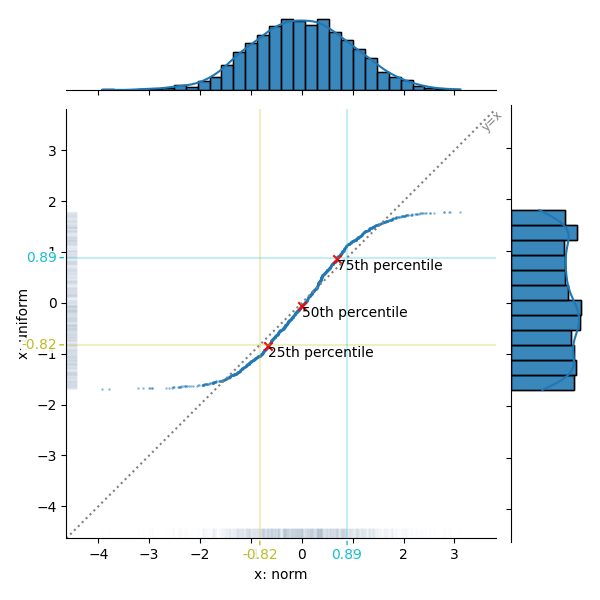

In [9]:
def qq_plot_fig(data, xy_col_name, col_name_which_IDs_samples, annotate_quantiles=[], **kwargs):
    '''Creates a QQ-plot based on the input DataFrame to compare distribution of two samples.

    Uses sns scatterplot, so any keywords which are accepted by that can be passed through.
    The two samples MUST be of equal length.

    Args:
        data (_type_): _description_
    '''
    sample_names, counts = np.unique(data[col_name_which_IDs_samples], return_counts=True)
    assert len(sample_names)==2
    assert counts[0]==counts[1]

    sample_a_name, sample_b_name = sample_names
    sample_a_name_new = xy_col_name+': '+sample_a_name
    sample_b_name_new = xy_col_name+': '+sample_b_name
    
    # print(sample_a_name, sample_b_name)
    a = data[data[col_name_which_IDs_samples] == sample_a_name ]
    b = data[data[col_name_which_IDs_samples] == sample_b_name ]
    
    a_sorted = a.sort_values(by=xy_col_name).rename(columns={xy_col_name:sample_a_name_new}).reset_index()
    b_sorted = b.sort_values(by=xy_col_name).rename(columns={xy_col_name:sample_b_name_new}).reset_index()

    rearranged = pd.concat([a_sorted, b_sorted], axis=1, )

    plot = sns.jointplot(data=rearranged,  x=sample_a_name_new, y=sample_b_name_new, kind='scatter', 
                  joint_kws=dict(s=3, marker='o', alpha=.5, linewidth=0), **kwargs)
    plot.plot_marginals(sns.histplot, kde=True)
    plot.plot_joint(sns.rugplot, alpha=.01,)# height=-.15, )#clip_on=False)
    
    lims = [min(plt.ylim()[0], plt.xlim()[0]),    max(plt.ylim()[1], plt.xlim()[1])]
    plt.xlim(lims)
    plt.ylim(lims)
    plt.gca().set_aspect('equal')

    # add y=x line
    plt.gca().plot(lims, lims, c='gray', ls=':')
    plt.annotate(text='y=x', xy=(lims[1],lims[1]), c='gray', size='small',
                    va='top', ha='right', rotation=45, rotation_mode='anchor', )

    if type(annotate_quantiles)==int:   annotate_quantiles=np.linspace(0,1,annotate_quantiles, endpoint=False)[1:]
    annotation_idxs = (np.array(annotate_quantiles)*(len(rearranged)-1)).round().astype(int)
    # print(annotate_quantiles, annotation_idxs)
    for annotation_idx in annotation_idxs:
        point = rearranged.iloc[annotation_idx]
        # print(point)
        annotation_text = str(round(annotation_idx/len(rearranged)*100)) + 'th percentile'
        plt.annotate(annotation_text, xy=(point[sample_a_name_new], point[sample_b_name_new]), va='top')
        plt.scatter(point[sample_a_name_new], point[sample_b_name_new], c='r', marker='x')


    # plot vertical and horizontal lines at the location of the greatest deviations between the distributions
    test_results = [scipy.stats.ks_2samp(a.x, b.x, alternative='less'),
                    scipy.stats.ks_2samp(b.x, a.x, alternative='less'),]
    
    greatest_CDF_dists = sorted([test_result.statistic_location for test_result in test_results if test_result.pvalue<0.05])
    # print(*greatest_CDF_dists, sep='\n')
    
    for i, greatest_CDF_dist in enumerate(greatest_CDF_dists):
        color_this_bit = sns.color_palette()[8+i]

        # plot a vertical line at the location of the greatest deviations between the distributions
        axvline_with_xtick(ax=plt.gca(), x=greatest_CDF_dist, colour=color_this_bit,)
        axhline_with_ytick(ax=plt.gca(), y=greatest_CDF_dist, colour=color_this_bit,)


qq_plot_fig(data=two_samples_Normal_Uniform, xy_col_name='x', col_name_which_IDs_samples='type',  annotate_quantiles=4, )

#### Draw a figure including the PDFs, CDFs, and QQ-plot

And now we need to create a function which uses the previous (axes-based) functions to plot the PDFs for both samples, and the CDFs for both samples, and then a QQ-plot.  

To visually show the difference between the two distributions, on the CDF we will have markers showing the location of the greatest distance between the two CDFs. The distance itself will also be written on the plot, this is the statistic used by the Kolmogorov-Smirnov test, as will be discussed.    

Similarly, on the plot with the PDFs, we will shade the area representing the difference between the cumulative densities of the two curves, at the points where the distance is greatest.

Similarly, on the QQ-plot, we will draw a box around the points representing the difference between the cumulative densities of the two distributions, at those points where the difference is greatest.

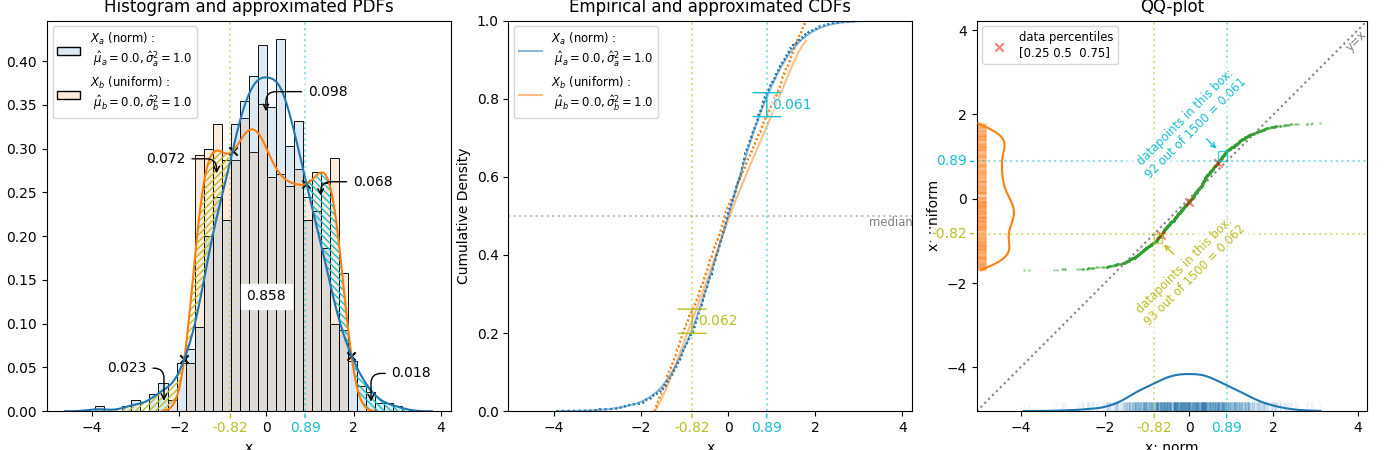

In [10]:
def plot_two_samples(both_samples):
    '''Creates various plots which visually show the difference between two distributions.

    Takes a pandas dataframe with the data of the two samples.
    - The column 'x' contains the observations, 
    - the column 'type' contains the name of the sample:
        the two samples must be of equal size, len(a)==len(b).
    This function uses the data to plot three axes:
        ax1: the PDFs of both samples, using histograms and KDE plots
        ax2: the CDFs of both samples, using the empirical CDF and the KDE estimated CDF
        ax3: the QQ-plot of the two samples. Includes a visualisation of the marginal distributions of both samples.
    To show differences in the distributions, the Kolmogorov-Smirnov test statistic is shown.
        On ax2, this is a line between the two CDFs at the location where the difference is greatest.
        On ax1, the areas between the curves corresponding to those statistics is shaded.
        And on as3, this is a box around the corresponding datapoints.
        
    Args:
        both_samples (DataFrame): contains the data of the two samples, as described

    Returns:
        ax1, ax2, ax3: the three axes, as described
    '''

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,4.5), 
                                        # tight_layout=True,
                                        # constrained_layout=True,
                                        )
    # for some reason, specifying tight_layout in plt.subplots messes up the positions of the additional axes 
    #  placed on top of the QQ-plot to show the KDEs of the marginals 
    #  - presumably because it moves the QQ plot only after the position of the KDEs of the marginals has already been fixed
    #       relative to the QQ plot - so once the QQ-plot is moved it doesn't match anymore.
    # But specifying it here doesn't mess it up 
    #  - presumably because the QQ-plot ax is originally placed according to tight_layout, 
    #       so KDE marginals are placed accordingly.
    plt.tight_layout()

    axvline_kwargs=dict(ls=':', alpha=.5)
    
    # ax1: PDFs of both samples
    pdfs_ax(both_samples, hist_kwargs={}, kde_kwargs={}, axvline_kwargs=axvline_kwargs, ax=ax1)

    # give all axs the same xlim. The ylim of the QQ plot should also be the same.
    ax2.set_xlim(*ax1.get_xlim())
    ax3.set_xlim(*ax1.get_xlim())
    ax3.set_ylim(*ax1.get_xlim())

    # ax2: CDFs of both samples
    cdfs_ax(both_samples, kde_kwargs={}, ecdf_kwargs={}, axvline_kwargs=axvline_kwargs, ax=ax2)

    # ax3: plot QQ-plot of the two samples
    qq_plot_ax(both_samples, xy_col_name='x', annotate_quantiles=4, 
               scatter_kwargs={}, rug_kwargs={}, kde_kwargs={}, axvline_kwargs=axvline_kwargs, ax=ax3)

    return ax1, ax2, ax3,


ax1, ax2, ax3,  = plot_two_samples(both_samples=two_samples_Normal_Uniform)



##### KS test statistic

**CDF:** The KS test statistic in its most recognised form is shown on the CDF: the greatest deviation between the two empirical CDFs. The locations of the deviations are marked on the x-axis. The first marker is for when one of the CDFs is greater, the second marker is for when the other CDF is greater. The markers are only shown if there is reasonable certainty that the deviations show that the distributions are different ($\alpha<0.05$).

**PDF:** The KS test statistic is also shown on the PDF, with the two regions shaded with diagonal lines. On the PDF, the KS test statistic is the difference between the area under the two curves, from $-\infty$ until the location where that difference in area is greatest.
So the first shaded region, on the left of the PDF, corresponds to the first deviation marked on the CDF. Note that the shaded region goes from $-\infty$ until the location marked on the CDF. And note that the area of where the second curve is higher than the first, minus the area of where the first curve is higher than the second, is close to the value of the statistic marked on the CDF. (Again, this isn't exact due to rounding of the areas, and due to treating the curves as polygons, and inaccuracies of the KDE approximation).  
Similarly, the second shaded region, on the right of the PDF, corresponds to the second deviation marked on the CDF. Note that the shaded region goes from the location marked on the CDF until $\infty$. And note that the area of where the second curve is higher than the first, minus the area of where the first curve is higher than the second, is close to the value of the statistic marked on the CDF.  
We also see on the PDF that the locations of the two KS test statistics are at an intersection of the two PDF lines. This makes perfect sense: The PDF is the rate of change of the CDF. So the difference between the two CDFs continues to increase, for as long as one PDF curve is above the other. Once the other PDF curve goes higher, then the difference between the CDFs will begin to decrease - so the greatest difference will be as this changes, i.e. at the intersection on the PDF.  

**QQ-plot:** Finally, the KS test statistic is also shown on the QQ-plot, with the two boxes around points. On the QQ-plot, the KS test statistic is the difference between the number of points below a horizontal line at a fixed position, and the number of points before a vertical line at the same fixed position - where the position is chosen in such a way as to maximise that difference. Thus the important places to look at are the North West quadrant and the South East quadrant. Looking at the annotations on the QQ-plot, this clearly corresponds to the values annotated on the CDF.


#### Statistical tests

Finally, we create a function which can test two samples for equal means, variances, and distribution (2-sided):

In [11]:
def stats_tests_mean_sd_dist_2_sided(data, col_name_which_IDs_samples='type'):
    sample_a_name, sample_b_name = np.unique(data[col_name_which_IDs_samples])

    a = data[data[col_name_which_IDs_samples]==sample_a_name].x.values
    b = data[data[col_name_which_IDs_samples]==sample_b_name].x.values

    test_results = [
        scipy.stats.ttest_ind(a, b),
        scipy.stats.bartlett(a,b),
        scipy.stats.ks_2samp(a, b, alternative='two-sided'),
        ]
    
    test_names = [type(test_result).__name__ for test_result in test_results]

    test_results = [test_result._asdict() for test_result in test_results]

    df = pd.DataFrame(test_results, index=test_names)
    df.insert(0, column='test', value=[name.replace('Result', '') for name in test_names])

    return df

# stats_tests_mean_sd_dist_2_1_sided(data=two_samples_Normal_different_means)

### Example #1: data from the Normal distribution and from the Uniform distribution

Now we can use those functions to generate two samples with identical mean $\mu=0$ and variance $\sigma^2=1$, one Normal and the other Uniform. (This is the same as what we've been using as an example previously). Then we can draw all those plots to visualise the data:

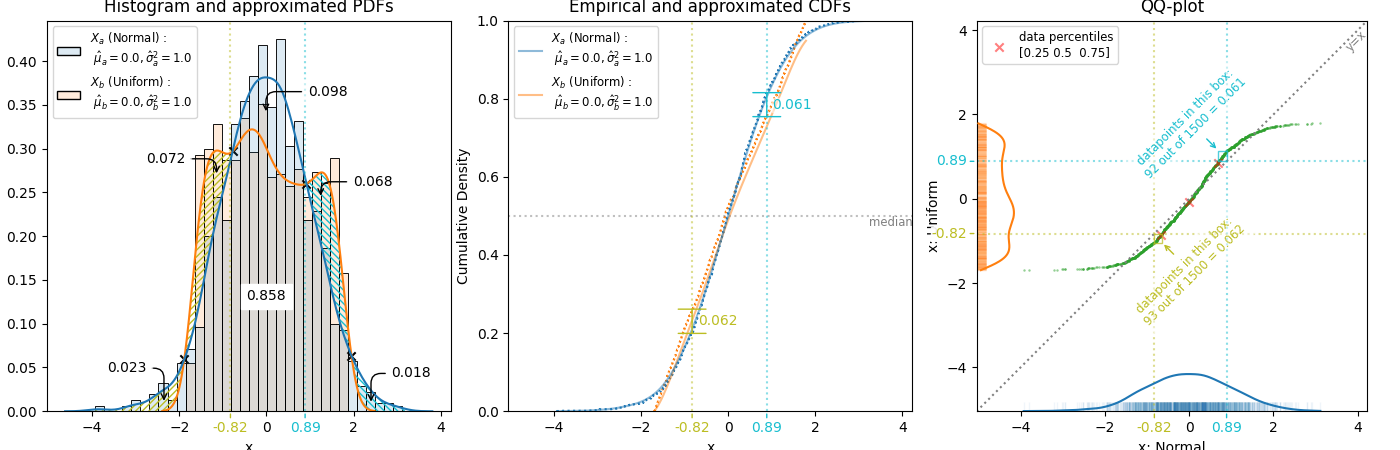

In [12]:

two_samples_Normal_Uniform = generate_two_samples(
                        a_dist=scipy.stats.norm,    sample_a_name='Normal', 
                        b_dist=scipy.stats.uniform, sample_b_name='Uniform', 
                        size=1500, display_description=False, seed=0)

plot_two_samples(both_samples=two_samples_Normal_Uniform)

plt.show()

So although mean and variance are identical for the two samples, nonetheless the distributions are clearly very different. In this case the difference is so pronounced that this can be seen clearly even on the PDF histogram/KDE and on the CDF plots, and is even clearer on the QQ-plot.

#### Notes about the plots:   
- The first two plots have light vertical lines which indicate the position of the maximum deviation between the two CDFs. In the above example, these are located at approximately $\pm0.80$.
- To further show the greatest deviations between the CDFs, the distance between them at these positions is marked with an $\textbf{I}$, annotated with the value of that distance (which is the statistic of the KS test). 
- Similarly, to show these greatest deviations on the PDFs also, the area between the PDFs before and after these positions are shaded with diagonal lines. For example, there is / shading between $[-\infty, -0.8]$, because if you subtract the area where the orange line is above the blue line, from the area where the blue line is above the orange line, it is greatest going up to $-0.8$. This is because after $-0.8$ the blue line rises above the orange line again, so the total "orange area minus blue area" starts decreasing. This corresponds to the first mark on the CDF. (The second mark on the CDF is shown using \ shading, and for clarity goes from the place of greatest deviation to the right, i.e. $[0.8, \infty]$.)
- On the QQ-plot, these are shown with annotated boxes.
- All these indications are given consistent colours through all three plots. 
- In the second plot, the solid orange line is the approximated CDF of the Uniform sample. Any smoothing at the top and bottom of the CDF is inappropriate here, as the uniform CDF should be a straight line. The dotted line is the empirical CDF, and this is straight, as would be expected.

We now use statistical tests to identify differences between the two samples:

In [13]:
stats_tests_mean_sd_dist_2_sided(data=two_samples_Normal_Uniform)

,test,statistic,pvalue,statistic_location,statistic_sign
Ttest_indResult,Ttest_ind,-4.313415e-15,1.000000,NaN,NaN
BartlettResult,Bartlett,-3.327339e-13,1.000000,NaN,NaN
KstestResult,Kstest,6.200000e-02,0.006253,-0.824785,-1.0


The first test, the **T-test**, is for means: If in truth the two RVs have the same mean, what is the probability of the two samples being observed? Or to be more precise, what is the probability of observing two samples which have an equal or greater difference between their means? This has a $p$-value of 1 - it is highly probable (because there is *no* difference between the means of the two samples). 

The second test, **Bartlett's test**, is for variance: If the two RVs essentially have the same variance, what is the probability of the two samples being observed (i.e. of the observed samples having a greater or equal difference in their variances)? Again, this has a $p$-value of 1 - it is highly probable. 

The final test is the **Kolmogorov-Smirnov test**. This is the standard method for comparing the entire distribution. Here, it convincingly rejects the suggestion that the two RVs have the same distribution: if they did, then the probability of the two samples being observed (i.e. two samples whose distribution differs by that much or more) would be minute. We therefore reject that and conclude that the two samples are drawn from different RVs.


### Example #2: data from the Normal distribution and from the T distribution

With Normal and Uniform data, the fact that they are different was immediately visually obvious. 

A less obvious example compares the Normal distribution to the [T-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution). The data is drawn from $t_6$, so $\nu=6$, i.e. 6 degrees of freedom. As $\nu \to \infty$,  $t_\nu$ becomes the standard Normal distribution $\mathcal{N}(0,1)$, but for $\nu=6$ there are still significant differences between the distributions which can be picked up with a modest sample size:

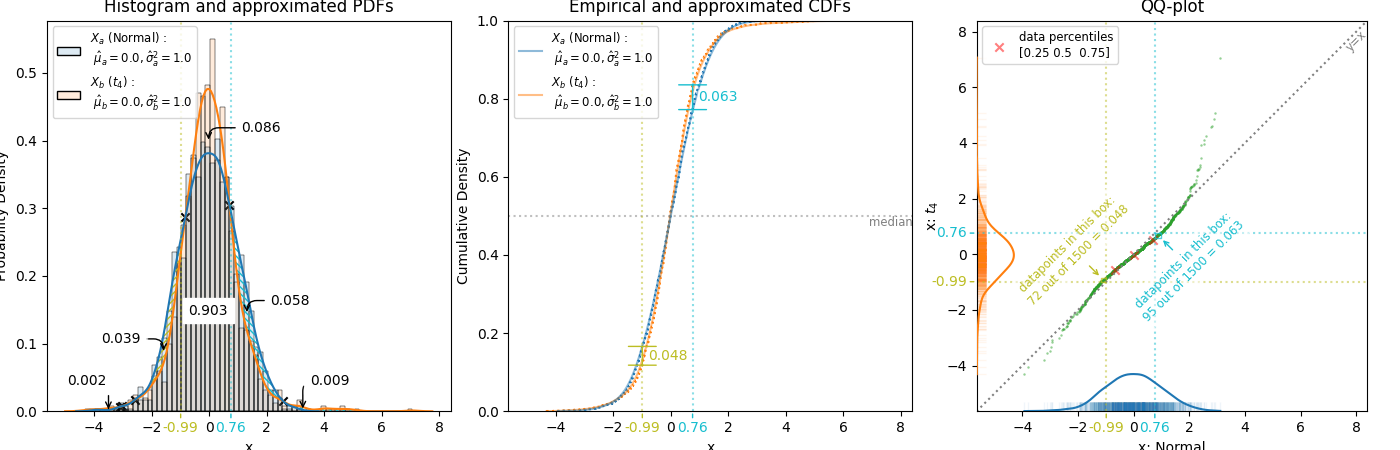

In [14]:
t_df=4
sample_b_name='T [df='+str(t_df)+']'
sample_b_name='$t_'+str(t_df)+'$'
two_samples_Normal_T = generate_two_samples(
                        a_dist=scipy.stats.norm,    a_kwargs={},        sample_a_name='Normal',
                        b_dist=scipy.stats.t,       b_kwargs={'df':t_df},  sample_b_name=sample_b_name,
                        size=1500,      display_description=False,       seed=0)

plot_two_samples(both_samples=two_samples_Normal_T)
plt.show()


- Here, the PDFs are similar, although differences can be seen. 
- Visual inspection of the CDFs doesn't really reveal any difference. 
- This is where the QQ-plot comes in useful - it makes it very clear that the T distribution has heavier tails than the Normal does. This is shown because points which are the same quantile in both samples have greater values on the y-axis, representing the T-distribution, than they do on the x-axis, which represents the Normal distribution. In other words, the tails of the T are heavier.

However the QQ-plot is not a rigorous test in that it doesn't quantify its findings. Once again we will run the three tests for mean, variance, and distribution:

In [15]:
stats_tests_mean_sd_dist_2_sided(data=two_samples_Normal_T)

,test,statistic,pvalue,statistic_location,statistic_sign
Ttest_indResult,Ttest_ind,-8.756556e-16,1.000000,NaN,NaN
BartlettResult,Bartlett,1.514108e-28,1.000000,NaN,NaN
KstestResult,Kstest,6.333333e-02,0.004866,0.760886,1.0


And again we find that there is no evidence that the means are different; and no evidence that the variances are different; but strong evidence that the distributions are different. If the sample sizes were bigger, the evidence would be expected to be even stronger.

### Example #3: data from the Normal distribution, with different means

We now look at data from the same distribution, and with the same variance, but with slightly different means:


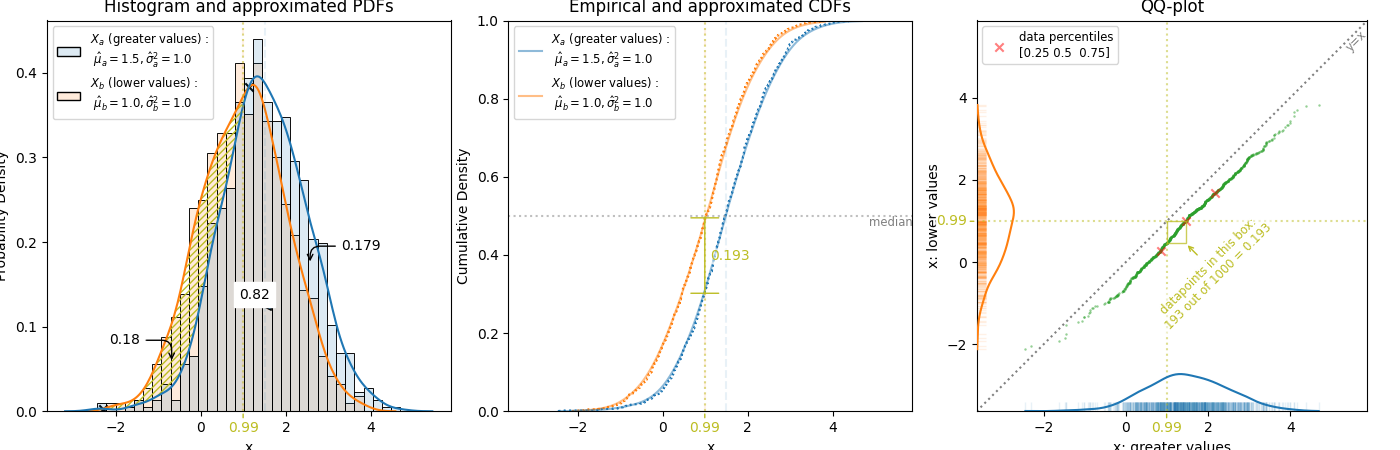

In [16]:
two_samples_Normal_different_means = generate_two_samples(
                        a_dist=scipy.stats.norm,  a_mean=1.5, a_std=1,     sample_a_name='greater values',
                        b_dist=scipy.stats.norm,  b_mean=1, b_std=1, sample_b_name='lower values',
                        size=1000,      display_description=False,       seed=0)

plot_two_samples(both_samples=two_samples_Normal_different_means)
plt.show()


In these examples, sample a has a greater mean that sample b does. 

It is worth looking at the plots to understand this graphically, as this will build intuition which will be required later for one-sided KS tests: 

- Looking carefully at the PDFs, we see that the blue data are more to the right, indicating that sample a tends to be greater than sample b.
- The CDFs require a bit more thought: The blue CDF is *lower* than the orange one, indicating that for any given value of $x$, sample a has a *lower* probability of being *less* than that value than sample b does - i.e. again indicating that sample a tends to be ***greater*** than sample b.
- The QQ-plot shows that the points are in a straight line, because both distributions are the same. However the points are all slightly below the $y=x$ diagonal line. So values of b (the y-axis) are lower than corresponding values of a (x-axis) (additive shift).

Looking at the statistical tests:

In [17]:
stats_tests_mean_sd_dist_2_sided(data=two_samples_Normal_different_means)

,test,statistic,pvalue,statistic_location,statistic_sign
Ttest_indResult,Ttest_ind,1.118034e+01,3.428057e-28,NaN,NaN
BartlettResult,Bartlett,-1.108558e-13,1.000000e+00,NaN,NaN
KstestResult,Kstest,1.930000e-01,1.072206e-16,0.991837,-1.0


As expected:  
- the T-test shows that the mean is different
- the Bartlett test doesn't tell us that the variance is different (as it is in fact the same). 
- and since the mean is different, the distribution is different as well (even though both are normal) - so the KS test also tells us to reject.

### One-sided KS tests

The advantage of the Kolmogorov-Smirnov test is that it can easily be used to test for whether one distribution is greater than the other. The above test was two-sided, so it would have rejected (given a small $p$-value) if the CDF of the first was greater, or if the CDF of the second was greater. But with one-sided tests, we can test for just one way. On the graphs above, the greatest deviations are shown both ways, using two one-sided tests, one in each direction.  

It takes some time to get used to the way this works, as this can be confusing with a lot of double negatives. Let's try to think it through with the help of a few examples to illustrate.  

First, we need to add a statistical testing function to include one-sided tests:

In [18]:
def stats_tests_mean_sd_dist_1_sided(data, col_name_which_IDs_samples='type'):
    sample_a_name, sample_b_name = np.unique(data[col_name_which_IDs_samples])

    a = data[data[col_name_which_IDs_samples]==sample_a_name].x.values
    b = data[data[col_name_which_IDs_samples]==sample_b_name].x.values


    test_results = [
        scipy.stats.ttest_ind(a, b, alternative='less'),
        scipy.stats.ttest_ind(a, b, alternative='greater'),
        # scipy.stats.bartlett(a,b),
        # scipy.stats.ks_2samp(a, b, alternative='two-sided'),
        scipy.stats.ks_2samp(a, b, alternative='less'),
        scipy.stats.ks_2samp(a, b, alternative='greater'),
        ]
    
    test_names = [type(test_result).__name__ for test_result in test_results]

    test_results = [test_result._asdict() for test_result in test_results]

    alternative = ['less', 'greater',
                    'less', 'greater']
    alternative_explained = ['mean('+sample_a_name+ ') is less', 'mean('+sample_a_name+ ') is greater',
                    'CDF('+sample_a_name+ ') is less', 'CDF('+sample_a_name+ ') is greater']
    details = [test_result.__str__() for test_result in test_results]
    # print(*details, sep='\n')

    df = pd.DataFrame(test_results, index=test_names)
    df.insert(0, column='test', value=[name.replace('Result', '') for name in test_names])
    df.insert(1, column='alternative', value=alternative)
    df.insert(2, column='alternative_explained', value=alternative_explained)
    # df.insert(4, column='details', value=details)

    return df#.round(7)


In [19]:
stats_tests_mean_sd_dist_2_sided(data=two_samples_Normal_different_means) 

,test,statistic,pvalue,statistic_location,statistic_sign
Ttest_indResult,Ttest_ind,1.118034e+01,3.428057e-28,NaN,NaN
BartlettResult,Bartlett,-1.108558e-13,1.000000e+00,NaN,NaN
KstestResult,Kstest,1.930000e-01,1.072206e-16,0.991837,-1.0


In [20]:
stats_tests_mean_sd_dist_1_sided(data=two_samples_Normal_different_means)

,test,alternative,alternative_explained,statistic,pvalue,statistic_location,statistic_sign
Ttest_indResult,Ttest_ind,less,mean(greater values) is less,11.18034,1.000000e+00,NaN,NaN
Ttest_indResult,Ttest_ind,greater,mean(greater values) is greater,11.18034,1.714028e-28,NaN,NaN
KstestResult,Kstest,less,CDF(greater values) is less,0.19300,5.361032e-17,0.991837,-1.0
KstestResult,Kstest,greater,CDF(greater values) is greater,0.00200,9.960100e-01,-2.310978,1.0


Looking at those values is puzzling. For the T-test, we reject the null when the alternative is *greater*. But for the KS-test, we reject the null when the alternative is *less*.  

How does that make sense?  

The scipy documentation is usually the epitome of clarity, but for the [KS test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html) it leaves a fair amount unsaid. So let's go through this carefully: there are multiple negatives here in the language of hypothesis testing, so this needs to be thought through.  

##### `scipy.stats.ks_2samp(a, b, alternative='less')`  
- This means that the alternative hypothesis states that sample **a** has a CDF which is **less** than the CDF of sample **b** : $H_1 \ : \ F_a(x) < F_b(x) $.  
- Thinking about the values of the data, this means that the alternative hypothesis can be proven if sample a (at least at some point of the empirical CDF) has values which are significantly **greater** than the values of sample b, as **greater** values means that the CDF will be **lower**.  
- So the **null** hypothesis states that sample a has a CDF which is **greater than or equal to** than the CDF of sample **b** : $H_0 \ : \ F_a(x) \geq F_b(x) $.
- Thinking about the values of the data, this means that according to the **null** hypothesis, we expect that sample a will have values which are generally **less than or equal to** the values of sample b, as **lower** values means that the CDF will be **greater**.  
- So in our case, sample a is the values with the greater mean. As the values of sample a tend to be greater, the CDF of sample a will tend to be lower, as the alternative hypothesis believes. So we would expect the null for this alternative hypothesis to be **rejected**, in favour of the alternative.  
- This is indeed what happens: in the second last row of the previous table, we have a very low $p$-value, showing that the data is very improbable according to the null. 
- I.e. $\text{P}(X_a, X_b \ | \ H_0 \ : \ F_a(x) \geq F_b(x) ) < 0.05$, so we reject at the standard level of 0.05 (and much lower also). 

##### `scipy.stats.ks_2samp(a, b, alternative='greater')`   
- This means that the alternative hypothesis states that sample **a** has a CDF which is **greater** than the CDF of sample **b** : $H_1 \ : \ F_a(x) > F_b(x) $.    
- Thinking about the values of the data, this means that the alternative hypothesis can be proven if sample a (at least at some point of the empirical CDF) has values which are significantly **less** than the values of sample b, as **lower** values means that the CDF will be **greater**.    
- So the **null** hypothesis states that sample a has a CDF which is **less than or equal to** than the CDF of sample **b** : $H_0 \ : \ F_a(x) \leq F_b(x) $.  
- Thinking about the values of the data, this means that according to the **null** hypothesis, we expect that sample a will have values which are generally **greater than or equal to** the values of sample b, as **greater** values means that the CDF will be **lower**.  
- So in our case, sample a is the values with the greater mean. As the values of sample a tend to be greater, the CDF of sample a will tend to be lower, which fits perfectly well with the null hypothesis. So we would expect to **fail to reject** the null for this alternative hypothesis, as looking at the data, the null makes perfect sense.  
- This is indeed what happens: in the last row of the previous table, we have a very high $p$-value of almost $1$, showing that the data is very probable according to the null.  
- I.e. $\text{P}(X_a, X_b \ | \ H_0 \ : \ F_a(x) \leq F_b(x) ) > 0.05$, so we don't reject at the standard level of 0.05 (and much higher also).  

Reproducing the plots of this dataset is helpful in thinking through this process:  


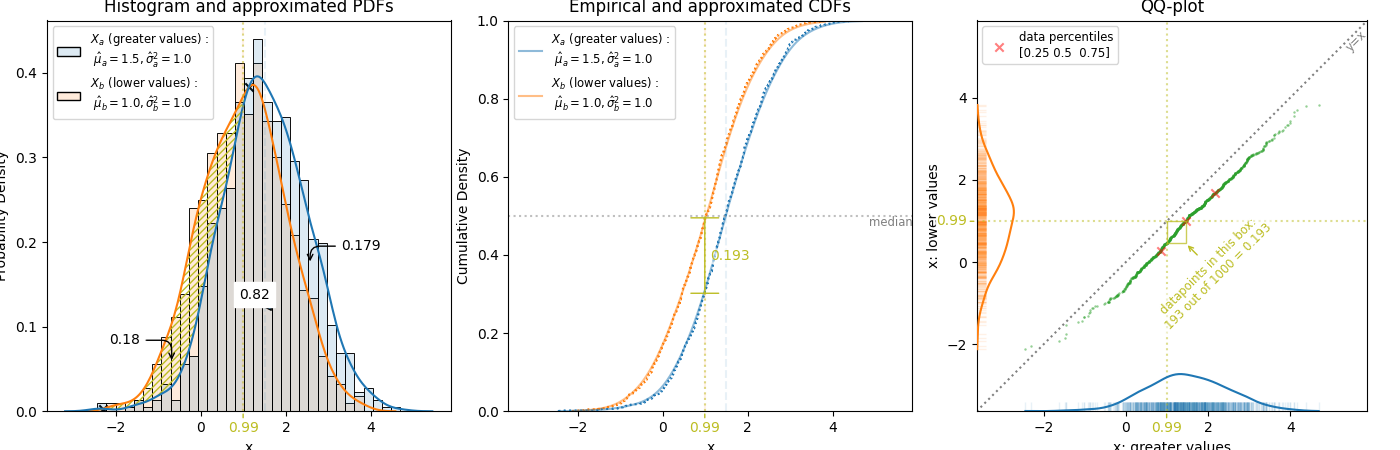

In [21]:
plot_two_samples(both_samples=two_samples_Normal_different_means)
plt.show()


### Example #4: data from the Normal distribution, with different variance

We again look at data from the same distribution, but this time with the same means, and with slightly different variances:


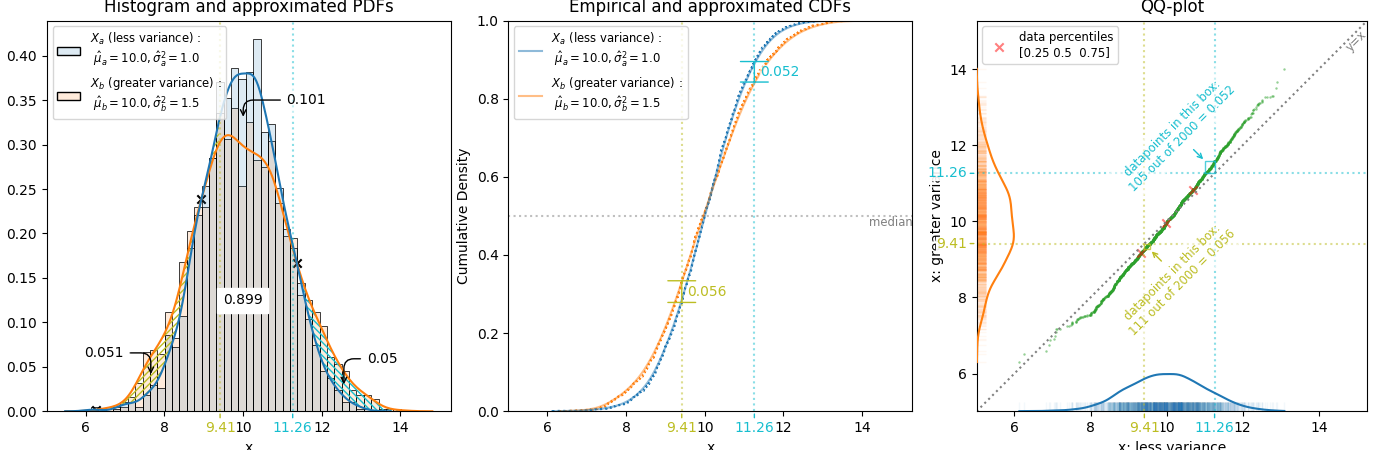

In [22]:
two_samples_Normal_different_variances = generate_two_samples(
                        a_dist=scipy.stats.norm,  a_mean=10, a_std=1,       sample_a_name='less variance',
                        b_dist=scipy.stats.norm,  b_mean=10, b_std=1.5**.5, sample_b_name='greater variance',
                        size=2000,      display_description=False,       seed=0)

plot_two_samples(both_samples=two_samples_Normal_different_variances)
plt.show()


- The PDFs and CDFs are self-explanatory
- The QQ-plot shows the quantiles are approximately in a straight line. This is because the distribution is the same, they are both Normal. However, they aren't on the $y=x$ line: on the y-axis there is a greater variance - because the y-axis plots the RV whose variance is indeed greater (multiplicative shift).

In [23]:
stats_tests_mean_sd_dist_2_sided(data=two_samples_Normal_different_variances) 

,test,statistic,pvalue,statistic_location,statistic_sign
Ttest_indResult,Ttest_ind,0.000000,1.000000e+00,NaN,NaN
BartlettResult,Bartlett,81.582761,1.680738e-19,NaN,NaN
KstestResult,Kstest,0.055500,4.215542e-03,9.414648,1.0


In [24]:
stats_tests_mean_sd_dist_1_sided(data=two_samples_Normal_different_variances) 

,test,alternative,alternative_explained,statistic,pvalue,statistic_location,statistic_sign
Ttest_indResult,Ttest_ind,less,mean(greater variance) is less,0.0000,0.500000,NaN,NaN
Ttest_indResult,Ttest_ind,greater,mean(greater variance) is greater,0.0000,0.500000,NaN,NaN
KstestResult,Kstest,less,CDF(greater variance) is less,0.0525,0.004031,11.260406,-1.0
KstestResult,Kstest,greater,CDF(greater variance) is greater,0.0555,0.002108,9.414648,1.0


- Here, the Bartlett test clearly rejects the hypothesis that the two samples have the same variance.
- The T-tests don't prove anything about whether the mean of the two samples is the same or not.
- The one-sided KS tests prove that the CDF of the first RV is less than the other CDF; and simultaneously proves the opposite, that the CDF of the first RV is greater than the other CDF. This is because in different locations the CDF is sometimes less and sometimes greater, as can be seen on the plots.

### Example #5: data from the Tukey-Lambda and Beta distributions

For fun we look at some less common distributions, [Tukey-Lambda](https://en.wikipedia.org/wiki/Tukey_lambda_distribution) and [Beta](https://en.wikipedia.org/wiki/Beta_distribution):


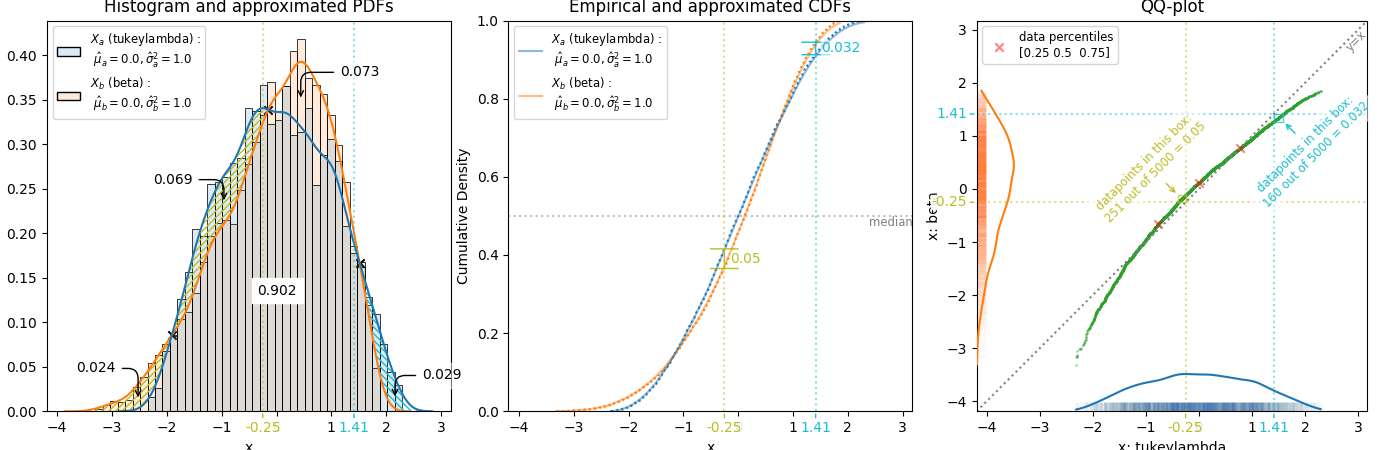

In [25]:
two_samples_exotic = generate_two_samples(
                        a_dist=scipy.stats.tukeylambda,     a_kwargs=dict(lam=.4), 
                        b_dist=scipy.stats.beta,            b_kwargs=dict(a=4, b=2), 
                        size=5000,      display_description=False,       seed=0)

ax1, ax2, ax3 = plot_two_samples(both_samples=two_samples_exotic)
plt.show()

In [26]:
stats_tests_mean_sd_dist_2_sided(data=two_samples_exotic) 

,test,statistic,pvalue,statistic_location,statistic_sign
Ttest_indResult,Ttest_ind,3.041123e-14,1.000000,NaN,NaN
BartlettResult,Bartlett,-1.109890e-12,1.000000,NaN,NaN
KstestResult,Kstest,5.020000e-02,0.000007,-0.25117,-1.0


In [27]:
stats_tests_mean_sd_dist_1_sided(data=two_samples_exotic) 

,test,alternative,alternative_explained,statistic,pvalue,statistic_location,statistic_sign
Ttest_indResult,Ttest_ind,less,mean(beta) is less,3.041123e-14,0.500000,NaN,NaN
Ttest_indResult,Ttest_ind,greater,mean(beta) is greater,3.041123e-14,0.500000,NaN,NaN
KstestResult,Kstest,less,CDF(beta) is less,5.020000e-02,0.000003,-0.251170,-1.0
KstestResult,Kstest,greater,CDF(beta) is greater,3.200000e-02,0.005974,1.412497,1.0
